In [2]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm
import json
import os

In [3]:
with open("/home/omar/projects/vqa-ir-qa/src/results/generation_metrics.json", "r") as f:
    raw_data = json.load(f)

In [4]:
# === Normalize into DataFrame ===
def build_dataframe(raw):
    rows = []
    for key, v in raw.items():
        rec = v.copy()
        rec['id'] = key
        rows.append(rec)
    df = pd.DataFrame(rows)
    df['correct_answers'] = df['correct_answers'].astype(int)
    df['total'] = df['total'].astype(int)
    df['accuracy_calc'] = df['correct_answers'] / df['total']
    return df

df = build_dataframe(raw_data)

In [5]:
# === Enrichment: baseline comparison, CIs, ranking ===
def two_prop_z_test(x1, n1, x2, n2):
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    se = sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    if se == 0:
        return np.nan, np.nan
    z = (p1 - p2) / se
    p_value = 2 * (1 - norm.cdf(abs(z)))
    return z, p_value

In [6]:
# Build baseline lookup (retriever == 'baselines')
baseline_df = df[df['retriever'] == 'baselines'][['model','correct_answers','total','accuracy']].set_index('model')
baseline_dict = baseline_df.to_dict(orient='index')

In [7]:
def compare_to_baseline(row):
    model = row['model']
    if model in baseline_dict:
        base = baseline_dict[model]
        z, p = two_prop_z_test(row['correct_answers'], row['total'],
                                base['correct_answers'], base['total'])
        row['baseline_accuracy'] = base['accuracy']
        row['accuracy_delta'] = row['accuracy'] - base['accuracy']
        row['z_vs_baseline'] = z
        row['pvalue_vs_baseline'] = p
    else:
        row['baseline_accuracy'] = np.nan
        row['accuracy_delta'] = np.nan
        row['z_vs_baseline'] = np.nan
        row['pvalue_vs_baseline'] = np.nan
    return row

df = df.apply(compare_to_baseline, axis=1)

In [8]:
# Wilson confidence intervals
df[['ci_lower','ci_upper']] = df.apply(
    lambda r: pd.Series(
        proportion_confint(count=r['correct_answers'], nobs=r['total'], alpha=0.05, method='wilson')
    ),
    axis=1
)

In [9]:
# Ranking within each top_k
df['rank_within_topk'] = df.groupby('top_k')['accuracy'].rank(ascending=False, method='dense')

In [10]:
# === Summaries ===
best_per_topk = []
for topk, group in df.groupby('top_k'):
    best = group.loc[group['accuracy'].idxmax()]
    best_per_topk.append({
        'top_k': topk,
        'best_retriever': best['retriever'],
        'best_model': best['model'],
        'accuracy': best['accuracy'],
        'baseline_accuracy': best.get('baseline_accuracy', np.nan),
        'accuracy_delta': best.get('accuracy_delta', np.nan),
        'pvalue_vs_baseline': best.get('pvalue_vs_baseline', np.nan)
    })
best_df = pd.DataFrame(best_per_topk)
best_df

,top_k,best_retriever,best_model,accuracy,baseline_accuracy,accuracy_delta,pvalue_vs_baseline
0,1,nomic-ai_colnomic-embed-multimodal-3b,OpenGVLab-InternVL3-8B-hf,0.595349,0.644961,-0.049612,0.066402
1,3,nomic-ai_colnomic-embed-multimodal-3b,OpenGVLab-InternVL3-8B-hf,0.555039,0.644961,-0.089922,0.000980
2,judged,baselines,OpenGVLab-InternVL3-8B-hf,0.644961,0.644961,0.000000,1.000000


In [11]:
# Display formatted outputs
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
print("=== Best model per top_k ===")
display(best_df.sort_values("top_k"))

print("\n=== Full enriched table ===")
display(df.sort_values(['top_k','accuracy'], ascending=[True, False]).reset_index(drop=True))

=== Best model per top_k ===


,top_k,best_retriever,best_model,accuracy,baseline_accuracy,accuracy_delta,pvalue_vs_baseline
0,1,nomic-ai_colnomic-embed-multimodal-3b,OpenGVLab-InternVL3-8B-hf,0.5953,0.6450,-0.0496,0.0664
1,3,nomic-ai_colnomic-embed-multimodal-3b,OpenGVLab-InternVL3-8B-hf,0.5550,0.6450,-0.0899,0.0010
2,judged,baselines,OpenGVLab-InternVL3-8B-hf,0.6450,0.6450,0.0000,1.0000



=== Full enriched table ===


,top_k,retriever,model,total,generation_successful,judgment_successful,correct_answers,incorrect_answers,generation_rate,judgment_rate,...,avg_judgment_time,id,accuracy_calc,baseline_accuracy,accuracy_delta,z_vs_baseline,pvalue_vs_baseline,ci_lower,ci_upper,rank_within_topk
0,1,nomic-ai_colnomic-embed-multimodal-3b,OpenGVLab-InternVL3-8B-hf,645,645,645,384,261,1.0000,1.0000,...,0.0767,1/nomic-ai_colnomic-embed-multimodal-3b/OpenGV...,0.5953,0.6450,-0.0496,-1.8357,0.0664,0.5570,0.6326,1.0000
1,1,nomic-ai_colnomic-embed-multimodal-7b,OpenGVLab-InternVL3-8B-hf,645,645,645,384,261,1.0000,1.0000,...,0.0774,1/nomic-ai_colnomic-embed-multimodal-7b/OpenGV...,0.5953,0.6450,-0.0496,-1.8357,0.0664,0.5570,0.6326,1.0000
2,1,nomic-ai_colnomic-embed-multimodal-7b,qwen2-5vl-7b,645,645,645,316,329,1.0000,1.0000,...,0.0773,1/nomic-ai_colnomic-embed-multimodal-7b/qwen2-...,0.4899,0.5333,-0.0434,-1.5596,0.1189,0.4515,0.5284,2.0000
3,1,nomic-ai_colnomic-embed-multimodal-3b,qwen2-5vl-7b,645,645,645,308,337,1.0000,1.0000,...,0.0780,1/nomic-ai_colnomic-embed-multimodal-3b/qwen2-...,0.4775,0.5333,-0.0558,-2.0048,0.0450,0.4392,0.5161,3.0000
4,1,nomic-ai_colnomic-embed-multimodal-3b,qwen2-5vl-3b,645,633,633,258,375,0.9814,0.9814,...,0.0740,1/nomic-ai_colnomic-embed-multimodal-3b/qwen2-...,0.4000,0.4534,-0.0458,-1.6346,0.1021,0.3629,0.4383,4.0000
5,1,nomic-ai_colnomic-embed-multimodal-7b,qwen2-5vl-3b,645,631,631,255,376,0.9783,0.9783,...,0.0740,1/nomic-ai_colnomic-embed-multimodal-7b/qwen2-...,0.3953,0.4534,-0.0493,-1.8051,0.0711,0.3583,0.4336,5.0000
6,1,nomic-ai_colnomic-embed-multimodal-3b,OpenGVLab-InternVL3-2B-hf,645,645,645,194,451,1.0000,1.0000,...,0.0782,1/nomic-ai_colnomic-embed-multimodal-3b/OpenGV...,0.3008,0.4264,-0.1256,-4.6884,0.0000,0.2666,0.3373,6.0000
7,1,nomic-ai_colnomic-embed-multimodal-7b,OpenGVLab-InternVL3-2B-hf,645,645,645,192,453,1.0000,1.0000,...,0.0786,1/nomic-ai_colnomic-embed-multimodal-7b/OpenGV...,0.2977,0.4264,-0.1287,-4.8086,0.0000,0.2637,0.3341,7.0000
8,1,nomic-ai_colnomic-embed-multimodal-7b,gemma3-12b-it-q4-K-M,645,645,645,78,567,1.0000,1.0000,...,0.0752,1/nomic-ai_colnomic-embed-multimodal-7b/gemma3...,0.1209,0.1271,-0.0062,-0.3379,0.7355,0.0980,0.1484,8.0000
9,1,nomic-ai_colnomic-embed-multimodal-3b,gemma3-12b-it-q4-K-M,645,645,645,76,569,1.0000,1.0000,...,0.0749,1/nomic-ai_colnomic-embed-multimodal-3b/gemma3...,0.1178,0.1271,-0.0093,-0.5096,0.6104,0.0952,0.1450,9.0000


In [12]:
df.shape

(30, 21)

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textwrap
import pandas as pd
from matplotlib.patches import Patch

def plot_accuracy(
    df: pd.DataFrame,
    retriever_name_map: dict | None = None,
    model_name_map: dict | None = None,
    base_palette: str = "pastel",  # light / soft colors
    show_values: bool = True,
    max_model_label_width: int = 20,
    ylim: tuple = (0, 1),
    dpi: int = 100,
):
    """
    Grouped bar plots by VLM model per top_k with light (pastel) colors.
    Oracle ('judged') is hatched; retrieval panels include baseline dashed ticks.
    """
    df = df.copy()
    sns.set_theme(style="whitegrid", font_scale=1.0)

    # Short-name helpers
    def _short_retriever(name: str) -> str:
        if name == "baselines":
            return "baseline"
        return name.replace("nomic-ai_", "").replace("colnomic-embed-multimodal", "embed").replace("_", "-")

    def _short_model(name: str) -> str:
        if name.startswith("OpenGVLab-InternVL3"):
            parts = name.split("-")
            if len(parts) >= 3:
                return f"{parts[1]}-{parts[2]}"
        if name.startswith("gemma3"):
            parts = name.split("-")
            if len(parts) >= 2 and "12b" in parts[1]:
                return f"{parts[0]}-{parts[1]}"
            return parts[0]
        if name.startswith("qwen2"):
            parts = name.split("-")
            if len(parts) >= 3:
                return f"{parts[0]}-{parts[-1]}"
        return name.replace("-hf", "")

    # Apply custom mapping / shortening
    df["short_model"] = df["model"].map(lambda m: model_name_map.get(m, _short_model(m)) if model_name_map else _short_model(m))
    df["short_retriever"] = df["retriever"].map(lambda r: retriever_name_map.get(r, _short_retriever(r)) if retriever_name_map else _short_retriever(r))
    df["label"] = df["short_retriever"] + "/" + df["short_model"]

    # Determine model ordering from oracle baseline if available
    baseline_df = df[(df["retriever"] == "baselines") & (df["top_k"] == "judged")]
    if not baseline_df.empty:
        order_models = (
            baseline_df.set_index("short_model")["accuracy"]
            .sort_values(ascending=False)
            .index.tolist()
        )
    else:
        order_models = sorted(df["short_model"].unique())

    # Baseline accuracy lookup
    baseline_map = {row["short_model"]: row["accuracy"] for _, row in baseline_df.iterrows()}

    for topk in sorted(df["top_k"].unique(), key=lambda x: (str(x) != "judged", x)):
        subset = df[df["top_k"] == topk]
        is_oracle = str(topk) == "judged"

        if is_oracle:
            pivot = (
                subset[subset["retriever"] == "baselines"]
                .pivot_table(index="short_model", columns="retriever", values="accuracy")
            )
        else:
            pivot = (
                subset[subset["retriever"] != "baselines"]
                .pivot_table(index="short_model", columns="short_retriever", values="accuracy")
            )
        if pivot.empty:
            continue

        # Enforce consistent model order
        existing_models = [m for m in order_models if m in pivot.index]
        pivot = pivot.reindex(existing_models)

        retrievers = pivot.columns.tolist()
        n_models = len(existing_models)
        group_width = 0.8
        bar_width = group_width / max(1, len(retrievers))
        x = np.arange(len(pivot))

        # Light palette per retriever (cycle if more than available)
        palette_colors = sns.color_palette(base_palette, n_colors=max(1, len(retrievers)))
        retriever_color_map = {retr: palette_colors[i % len(palette_colors)] for i, retr in enumerate(retrievers)}

        fig_width = max(10, n_models * 0.5)
        fig, ax = plt.subplots(figsize=(fig_width, 5), dpi=dpi)

        for i, retr in enumerate(retrievers):
            offsets = x - group_width/2 + (i + 0.5) * bar_width
            heights = pivot[retr].values
            if is_oracle:
                color = "#bbbbbb"  # soft gray for oracle
                hatch = "///"
                label = "oracle (judged)"
            else:
                color = retriever_color_map.get(retr, palette_colors[0])
                hatch = None
                label = retr
            bars = ax.bar(
                offsets,
                heights,
                width=bar_width * 0.9,
                edgecolor="black",
                linewidth=0.7,
                label=label,
                color=color,
                hatch=hatch,
                alpha=0.85,
            )
            if show_values:
                for rect in bars:
                    h = rect.get_height()
                    ax.text(
                        rect.get_x() + rect.get_width() / 2,
                        h + 0.01,
                        f"{h:.2f}",
                        ha="center",
                        va="bottom",
                        fontsize=7,
                    )

        # Baseline ticks (retrieval panels only)
        if not is_oracle and baseline_map:
            for idx, model in enumerate(existing_models):
                base_acc = baseline_map.get(model)
                if base_acc is None:
                    continue
                group_left = x[idx] - group_width / 2
                group_right = x[idx] + group_width / 2
                ax.hlines(
                    base_acc,
                    group_left + 0.05,
                    group_right - 0.05,
                    linestyles="dashed",
                    linewidth=1.2,
                    alpha=0.85,
                    color="black",
                    label="baseline" if idx == 0 else None,
                )

        # X-axis labels
        wrapped = ["\n".join(textwrap.wrap(m, max_model_label_width)) for m in existing_models]
        ax.set_xticks(x)
        ax.set_xticklabels(wrapped, rotation=45, ha="right")

        ax.set_ylim(*ylim)
        ax.set_ylabel("Accuracy")
        title_suffix = "oracle (judged)" if is_oracle else f"retrieval top-{topk}"
        ax.set_title(f"Accuracy by VLM model — {title_suffix}")

        # Subtle horizontal grid for reading across bars. Light background for clarity. :contentReference[oaicite:1]{index=1}  
        ax.yaxis.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
        ax.set_axisbelow(True)

        # Legend deduplication
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), frameon=False, loc="upper right")

        plt.tight_layout()
        plt.show()


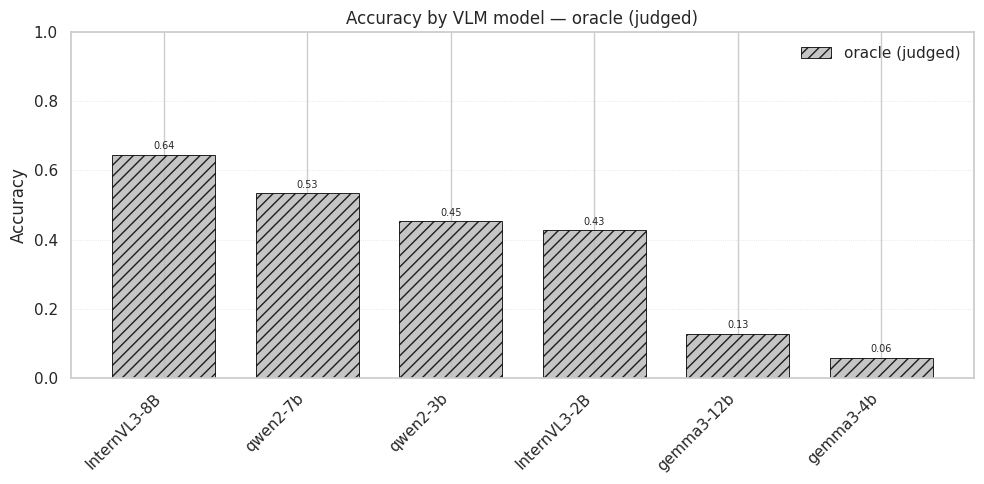

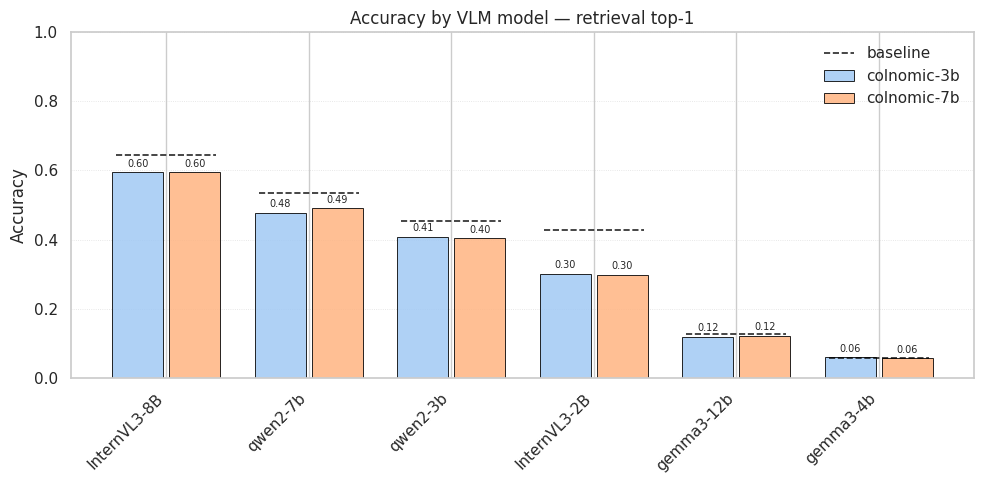

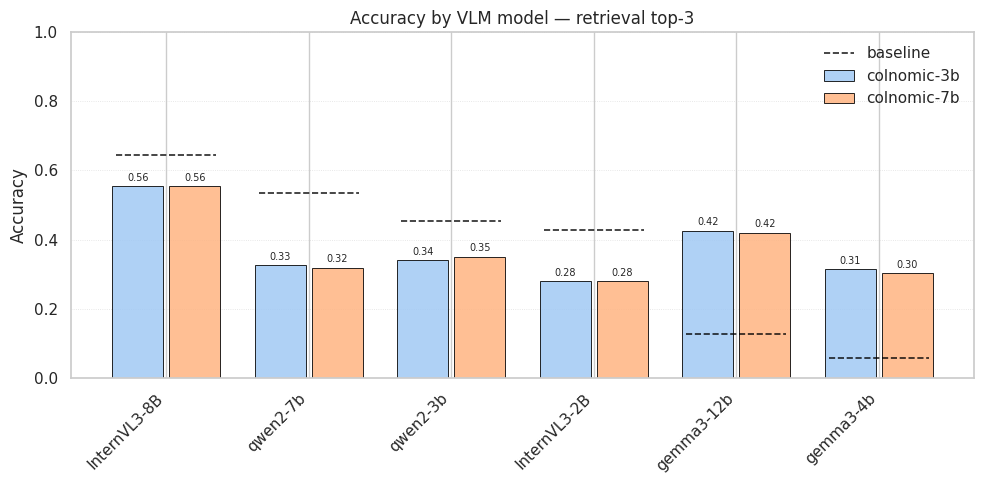

In [14]:
# Optionally supply custom short-name maps:
retr_map = {
    "nomic-ai_colnomic-embed-multimodal-3b": "colnomic-3b",
    "nomic-ai_colnomic-embed-multimodal-7b": "colnomic-7b",
    "baselines": "baseline"
}
model_map = {
    "OpenGVLab-InternVL3-8B-hf": "InternVL3-8B",
    "OpenGVLab-InternVL3-2B-hf": "InternVL3-2B",
    "gemma3-4b-it-q4-K-M": "gemma3-4b",
    "gemma3-12b-it-q4-K-M": "gemma3-12b",
    "qwen2-5vl-7b": "qwen2-7b",
    "qwen2-5vl-3b": "qwen2-3b",
}

plot_accuracy(df, retriever_name_map=retr_map, model_name_map=model_map, base_palette="pastel")


In [ ]:
# This is most likely due to prompt-model interaction

# Diagnosis: 
# Check whether top-3 contains duplicates of the oracle page and rerun ablations feeding Gemma3 one vs three copies.
# Manually inspect examples where Gemma3 succeeds at k=3 but fails at oracle; see what the other pages contain.
# Compare performance on oracle page alone vs oracle + random irrelevant pages vs oracle duplicated.